In [1]:
# STEP 1: Upload ZIP file manually
from google.colab import files
import zipfile
import os

uploaded = files.upload()
zip_filename = list(uploaded.keys())[0]
print(f"Uploaded file: {zip_filename}")

# STEP 2: Extract the ZIP
extract_dir = "/content/citrus_dataset"
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Detect inner folder if exists
extracted_subdirs = [f for f in os.listdir(extract_dir) if os.path.isdir(os.path.join(extract_dir, f))]
if len(extracted_subdirs) == 1:
    input_dir = os.path.join(extract_dir, extracted_subdirs[0])
else:
    input_dir = extract_dir

print(f"✅ Dataset directory set to: {input_dir}")
print("Subfolders (classes):", os.listdir(input_dir))


# STEP 3: Preprocessing
import cv2
import numpy as np
import pywt

output_dir = "/content/citrus_preprocessed"
os.makedirs(output_dir, exist_ok=True)

# Noise Removal
def remove_noise(img):
    blur = cv2.GaussianBlur(img, (5, 5), 0)
    median = cv2.medianBlur(blur, 5)
    bilateral = cv2.bilateralFilter(median, 9, 75, 75)
    return bilateral

# Image Enhancement
def enhance_image(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hist_eq = cv2.equalizeHist(gray)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    clahe_img = clahe.apply(hist_eq)
    return clahe_img

# Edge Detection
def edge_detection(img):
    edges_canny = cv2.Canny(img, 100, 200)
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    sobel = cv2.convertScaleAbs(sobelx + sobely)
    laplacian = cv2.Laplacian(img, cv2.CV_64F)
    laplacian = cv2.convertScaleAbs(laplacian)
    combined_edges = cv2.addWeighted(edges_canny, 0.5, sobel, 0.25, 0)
    combined_edges = cv2.addWeighted(combined_edges, 1.0, laplacian, 0.25, 0)
    return combined_edges

# Discrete Wavelet Transform
def apply_dwt(img):
    coeffs2 = pywt.dwt2(img, 'haar')
    LL, (LH, HL, HH) = coeffs2
    LL = np.uint8(LL)
    return LL

# Resize & Normalize
def resize_and_normalize(img, size=(128, 128)):
    resized = cv2.resize(img, size)
    normalized = (resized / 255.0 * 255).astype(np.uint8)
    return normalized

# Main Preprocessing Loop
for cls in os.listdir(input_dir):
    cls_input_path = os.path.join(input_dir, cls)
    cls_output_path = os.path.join(output_dir, cls)

    if not os.path.isdir(cls_input_path):
        continue
    os.makedirs(cls_output_path, exist_ok=True)

    print(f"Processing class: {cls}")

    for img_file in os.listdir(cls_input_path):
        img_path = os.path.join(cls_input_path, img_file)
        img = cv2.imread(img_path)
        if img is None:
            continue

        denoised = remove_noise(img)
        enhanced = enhance_image(denoised)
        edges = edge_detection(enhanced)
        dwt_img = apply_dwt(edges)
        normalized = resize_and_normalize(dwt_img)

        save_path = os.path.join(cls_output_path, img_file)
        cv2.imwrite(save_path, normalized)

print("✅ Preprocessed dataset saved to:", output_dir)


Saving Citrus.zip to Citrus.zip
Uploaded file: Citrus.zip
✅ Dataset directory set to: /content/citrus_dataset/Citrus
Subfolders (classes): ['Healthy', 'Greening', 'Melanose', 'Black spot', 'Canker']
Processing class: Healthy
Processing class: Greening
Processing class: Melanose
Processing class: Black spot
Processing class: Canker
✅ Preprocessed dataset saved to: /content/citrus_preprocessed


In [2]:
import cv2
import numpy as np
import os
import random

# Input & Output Directories
input_dir = "/content/citrus_preprocessed"
output_base = "/content/sd36"
os.makedirs(output_base, exist_ok=True)

# GrabCut Background Removal
def remove_background_grabcut(img):
    mask = np.zeros(img.shape[:2], np.uint8)
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)
    rect = (10, 10, img.shape[1] - 10, img.shape[0] - 10)
    cv2.grabCut(img, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)
    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
    return img * mask2[:, :, np.newaxis]

# Otsu's Thresholding Segmentation
def otsu_seg(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # Ensure leaf is foreground
    if np.mean(gray[mask == 255]) < np.mean(gray[mask == 0]):
        mask = cv2.bitwise_not(mask)
    return cv2.bitwise_and(img, img, mask=mask)

# Photometric Augmentation
def photometric_transform(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV).astype(np.float32)

    # Hue and saturation variation
    hue_shift = random.uniform(-10, 10)
    hsv[:, :, 0] = (hsv[:, :, 0] + hue_shift) % 180

    sat_scale = random.uniform(0.8, 1.2)
    hsv[:, :, 1] = np.clip(hsv[:, :, 1] * sat_scale, 0, 255)

    # Convert back to BGR
    img = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2BGR)

    # Gamma correction
    gamma = random.uniform(0.7, 1.3)
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(256)]).astype("uint8")
    img = cv2.LUT(img, table)

    return img

# Main Processing Loop
for cls in os.listdir(input_dir):
    cls_input_path = os.path.join(input_dir, cls)
    if not os.path.isdir(cls_input_path):
        continue

    # Output folders for both methods
    grabcut_out = os.path.join(output_base, "GrabCut_Photometric", cls)
    otsu_out = os.path.join(output_base, "Otsu_Photometric", cls)
    os.makedirs(grabcut_out, exist_ok=True)
    os.makedirs(otsu_out, exist_ok=True)

    print(f"Processing class: {cls}")

    for img_file in os.listdir(cls_input_path):
        img_path = os.path.join(cls_input_path, img_file)
        img = cv2.imread(img_path)
        if img is None:
            continue

        # GrabCut + Photometric
        grabcut_img = remove_background_grabcut(img)
        cv2.imwrite(os.path.join(grabcut_out, img_file), grabcut_img)

        for i in range(5):
            aug_img = photometric_transform(grabcut_img)
            cv2.imwrite(os.path.join(grabcut_out, f"grabcut_photo_aug_{i}_{img_file}"), aug_img)

        # Otsu + Photometric
        otsu_img = otsu_seg(img)
        cv2.imwrite(os.path.join(otsu_out, img_file), otsu_img)

        for i in range(5):
            aug_img = photometric_transform(otsu_img)
            cv2.imwrite(os.path.join(otsu_out, f"otsu_photo_aug_{i}_{img_file}"), aug_img)

print("✅ Combined Processing Complete!")
print(f"Results saved under: {output_base}")


Processing class: Healthy
Processing class: Greening
Processing class: Melanose
Processing class: Black spot
Processing class: Canker
✅ Combined Processing Complete!
Results saved under: /content/sd36


✅ All images merged into: /content/sd36_merged
Loaded 6677 images from /content/sd36_merged
Classes: ['Black spot', 'Canker', 'Greening', 'Healthy', 'Melanose']
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Using EfficientNetB0 with ImageNet weights.
Features shape: (6677, 1280)
Training SOM...


SOM Training Epochs: 100%|██████████| 50/50 [03:59<00:00,  4.79s/it]


Saved SOM assignments: /content/op36/som_assignments.npy

Metrics:
 Samples: 6677
Train: 5341
Test: 1336
Classes: [np.str_('Black spot'), np.str_('Canker'), np.str_('Greening'), np.str_('Healthy'), np.str_('Melanose')]

Accuracy: 0.9012
Precision: 0.9030
Recall: 0.9012
F1 Score: 0.9017
Specificity (avg): 0.9718
MAE: 0.1669
RMSE: 0.5680
Cross-Entropy Loss: 0.2638



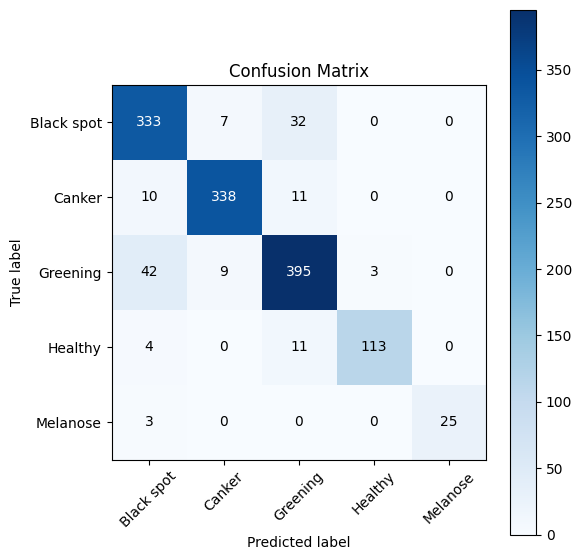

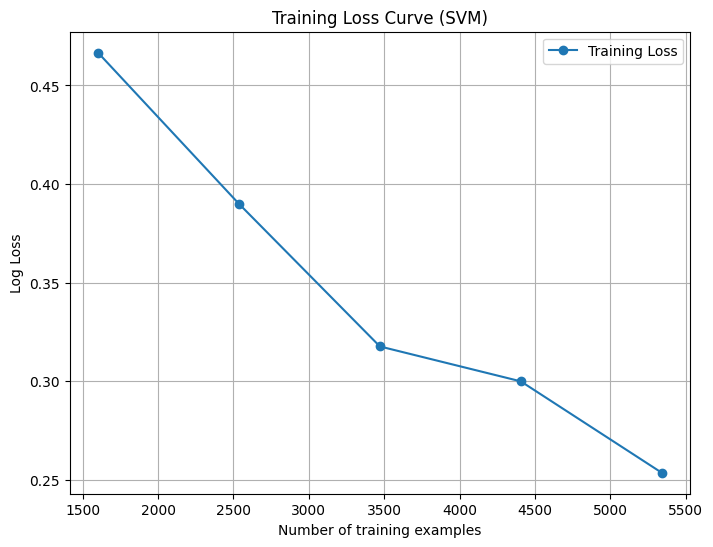

✅ All outputs saved to: /content/op36


In [3]:
import os
import shutil
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, mean_absolute_error, mean_squared_error, log_loss
)
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
import joblib
import matplotlib.pyplot as plt

# --- TensorFlow/Keras imports ---
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

# STEP 1: Merge GrabCut + Otsu datasets into one folder
input_dir = "/content/sd36"
merged_dir = "/content/sd36_merged"
os.makedirs(merged_dir, exist_ok=True)

for method in ["GrabCut_Photometric", "Otsu_Photometric"]:
    method_path = os.path.join(input_dir, method)
    if not os.path.exists(method_path):
        continue
    for cls in os.listdir(method_path):
        src_cls = os.path.join(method_path, cls)
        if not os.path.isdir(src_cls):
            continue
        dst_cls = os.path.join(merged_dir, cls)
        os.makedirs(dst_cls, exist_ok=True)
        for f in os.listdir(src_cls):
            src_f = os.path.join(src_cls, f)
            dst_f = os.path.join(dst_cls, f)
            shutil.copy(src_f, dst_f)

print("✅ All images merged into:", merged_dir)

# STEP 2: EfficientNet + SOM + SVM Pipeline
output_dir = "/content/op36"
os.makedirs(output_dir, exist_ok=True)

# Load images & labels
IMG_SIZE = (224, 224)
X_images, y_labels, class_names = [], [], []

for cls in sorted(os.listdir(merged_dir)):
    cls_path = os.path.join(merged_dir, cls)
    if not os.path.isdir(cls_path):
        continue
    class_names.append(cls)
    for f in os.listdir(cls_path):
        if f.lower().endswith((".jpg", ".jpeg", ".png")):
            p = os.path.join(cls_path, f)
            img = cv2.imread(p)
            if img is None:
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, IMG_SIZE)
            X_images.append(img)
            y_labels.append(cls)

if len(X_images) == 0:
    raise RuntimeError(f"No images found in {merged_dir}.")

X = np.array(X_images, dtype="float32")
y = np.array(y_labels)
print(f"Loaded {X.shape[0]} images from {merged_dir}")
print("Classes:", class_names)

# Encode labels
le = LabelEncoder()
y_enc = le.fit_transform(y)

# EfficientNet feature extractor
try:
    efficientnet80_feature_extractor = EfficientNetB0(include_top=False, pooling='avg', weights='imagenet',
                                                      input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    print("Using EfficientNetB0 with ImageNet weights.")
except Exception:
    efficientnet80_feature_extractor = EfficientNetB0(include_top=False, pooling='avg', weights=None,
                                                      input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    print("No internet, using EfficientNetB0 with random weights.")

def extract_features(batch):
    x = preprocess_input(batch.copy())
    return efficientnet80_feature_extractor.predict(x, verbose=0)

batch_size = 32
features_list = []
for i in range(0, X.shape[0], batch_size):
    batch = X[i:i+batch_size]
    feats = extract_features(batch)
    features_list.append(feats)
features = np.vstack(features_list)
print("Features shape:", features.shape)

# Simple SOM implementation
class SimpleSOM:
    def __init__(self, m, n, dim, n_iterations=100, alpha_start=0.5, sigma_start=None):
        self.m, self.n, self.dim = m, n, dim
        self.n_iterations = n_iterations
        self.alpha_start = alpha_start
        self.sigma_start = sigma_start if sigma_start is not None else max(m, n)/2.0
        self.weights = np.random.randn(m*n, dim).astype(np.float32)
        self.neuron_pos = np.array([[i, j] for i in range(m) for j in range(n)])

    def train(self, data):
        for it in tqdm(range(self.n_iterations), desc="SOM Training Epochs"):
            alpha = self.alpha_start * (1 - it / self.n_iterations)
            sigma = self.sigma_start * (1 - it / self.n_iterations)
            idxs = np.random.permutation(data.shape[0])
            for i in idxs:
                x = data[i]
                dists = np.linalg.norm(self.weights - x, axis=1)
                bmu_idx = np.argmin(dists)
                bmu_pos = self.neuron_pos[bmu_idx]
                dif = self.neuron_pos - bmu_pos
                sqd = np.sum(dif**2, axis=1)
                h = np.exp(-sqd / (2 * (sigma**2)))
                self.weights += (alpha * h[:, np.newaxis]) * (x - self.weights)
        return self

    def map_vectors(self, data):
        assignments = []
        for x in data:
            dists = np.linalg.norm(self.weights - x, axis=1)
            assignments.append(np.argmin(dists))
        return np.array(assignments)

som = SimpleSOM(10, 10, features.shape[1], n_iterations=50, alpha_start=0.5)
print("Training SOM...")
som.train(features)
som_assign = som.map_vectors(features)
np.save(os.path.join(output_dir, "som_assignments.npy"), som_assign)
print("Saved SOM assignments:", os.path.join(output_dir, "som_assignments.npy"))

# SVM classification
X_train, X_test, y_train, y_test = train_test_split(features, y_enc, test_size=0.2, random_state=42, stratify=y_enc)
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_train, y_train)
joblib.dump(svm, os.path.join(output_dir, "svm_model.pkl"))

y_pred = svm.predict(X_test)
y_pred_proba = svm.predict_proba(X_test)

# Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
cm = confusion_matrix(y_test, y_pred)

# Specificity Calculation
specificities = []
for i in range(cm.shape[0]):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - TP - FP - FN
    specificities.append(TN / (TN + FP) if (TN + FP) > 0 else 0)
specificity_avg = np.mean(specificities)

# MAE, RMSE, Cross-Entropy (Log Loss)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
try:
    cross_entropy = log_loss(y_test, y_pred_proba, labels=np.arange(len(class_names)))
except Exception as e:
    print("⚠️ Log Loss computation failed:", e)
    cross_entropy = np.nan

# Save & Display Metrics
metrics_text = (
    f"Samples: {len(y_enc)}\n"
    f"Train: {len(y_train)}\n"
    f"Test: {len(y_test)}\n"
    f"Classes: {list(le.classes_)}\n\n"
    f"Accuracy: {acc:.4f}\n"
    f"Precision: {prec:.4f}\n"
    f"Recall: {rec:.4f}\n"
    f"F1 Score: {f1:.4f}\n"
    f"Specificity (avg): {specificity_avg:.4f}\n"
    f"MAE: {mae:.4f}\n"
    f"RMSE: {rmse:.4f}\n"
    f"Cross-Entropy Loss: {cross_entropy:.4f}\n"
)
print("\nMetrics:\n", metrics_text)

with open(os.path.join(output_dir, "metrics.txt"), "w") as f:
    f.write(metrics_text)

# Confusion matrix plot with numbers inside
plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.colorbar()
classes = le.classes_
plt.xticks(np.arange(len(classes)), classes, rotation=45)
plt.yticks(np.arange(len(classes)), classes)
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "confusion_matrix.png"))
plt.show()

# Training loss curve (Log Loss)
train_sizes_frac = np.linspace(0.3, 1.0, 5)
train_loss_mean = []
for frac in train_sizes_frac:
    X_sub, y_sub = resample(X_train, y_train, n_samples=int(frac*len(X_train)),
                            stratify=y_train, random_state=42)
    svm_sub = SVC(kernel='rbf', probability=True, random_state=42)
    svm_sub.fit(X_sub, y_sub)
    y_pred_proba = svm_sub.predict_proba(X_sub)
    loss = log_loss(y_sub, y_pred_proba, labels=np.arange(len(class_names)))
    train_loss_mean.append(loss)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes_frac*len(X_train), train_loss_mean, marker='o', label='Training Loss')
plt.xlabel("Number of training examples")
plt.ylabel("Log Loss")
plt.title("Training Loss Curve (SVM)")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(output_dir, "training_loss_curve.png"))
plt.show()

# Save arrays
np.save(os.path.join(output_dir, "confusion_matrix.npy"), cm)
np.save(os.path.join(output_dir, "y_test.npy"), y_test)
np.save(os.path.join(output_dir, "y_pred.npy"), y_pred)
print("✅ All outputs saved to:", output_dir)
